# 연습문제2 — 한국은행(ECOS) 데이터 실습

> **주의(변경 금지)**: 아래에 제시된 모든 고정 파라미터는 시험 중 절대 변경하지 마세요. 학생은 **`api_key`**만 본인 키로 교체하고 코드를 실행하면 됩니다.

---

## 문제 개요
한국은행 ECOS API에서 재무상태표(stat_code=`501Y001`)의 **전산업(ZZZ00)** 항목을 내려받아 전처리(결측치 처리 포함) 후 시계열 시각화와 간단한 수치분석을 수행하시오. 분석 기간은 **2009년부터 2023년**까지입니다.

---

## 고정 파라미터 (절대 변경 금지)
- **통계표 코드 (stat_code)**: `501Y001` (재무상태표 — 연간)  
- **주기 (frequency)**: `A` (연간, Yearly) — 연도 단위(YYYY)  
- **세부항목 (item_code1)**: `ZZZ00` (전산업 / All industries)  
- **분석 기간**: `2009` (2009년) 부터 `2023` (2023년) 까지  
- **요청 URL 예시**:  
  ```
  https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/9999/501Y001/A/2009/2023/ZZZ00
  ```

---

## 제출물 (필수)
1. **전처리 결과 CSV**  
   - 파일명: `ecos_501Y001_ZZZ00_annual_cleaned.csv`  
   - 포함 컬럼(권장): `TIME`, `year`, `date`, `value`, `value_filled`, `ma_3`, `pct_yoy`  
   - `date`는 `YYYY-01-01` 형식의 datetime으로 표기하고, 인덱스로 사용할 수 있습니다.
2. **작성된 파이썬 코드**  
   - 연습문제2.ipynb

---

## 전처리 규칙 (명확히 지킬 것)
1. **시간 변환**  
   - API의 `TIME` 값은 연도형식(`YYYY`)입니다. `year` 컬럼(정수)을 만들고 `date` 컬럼은 `YYYY-01-01` 형식의 datetime으로 생성하세요.  
   - `date`를 DataFrame 인덱스로 설정하면 시계열 리샘플링/정렬이 용이합니다.
2. **값 처리**  
   - 값 컬럼(예: `DATA_VALUE` 형태)을 찾아서 문자열 내 쉼표(,)를 제거한 후 숫자형으로 변환하세요.  
   - 변환 불가능한 값은 `NaN`으로 처리합니다.
3. **결측치 처리 (명시적 규칙)**  
   - 모든 `NaN`은 **해당 열의 평균(mean)** 으로 대체합니다. 대체 후 새 컬럼명으로 `value_filled`를 사용하세요.  
   
4. **보조 컬럼 생성**  
   - `ma_3`: `value_filled`의 3년 이동평균 (pandas `rolling(window=3, min_periods=1).mean()`)  
   - `pct_yoy`: `value_filled`의 전년대비(%) = `(t - t-1) / t-1 * 100` (`pct_change(periods=1) * 100`)
5. **정렬 및 저장**  
   - 인덱스는 `date`로 오름차순 정렬(`sort_index()`)하고, 최종 DataFrame을 지정된 CSV 파일명으로 저장하세요 (`utf-8-sig` 권장).

---

## 분석/시각화 요구사항
### 1) Time series plot (필수)  
- **내용**: `value_filled`(원본 결측 대체값)와 `ma_3`(3-year moving average)를 같은 플롯에 겹쳐 표시하세요.  
- **레이블(영어 권장)**: Title = `"Balance Sheet - All Industries (Annual)"`, x = `"Year"`, y = `"Amount (unit as provided by API)"`  
- **파일명**: `timeseries_501Y001_ZZZ00.png`  
- **요구사항**: 범례(legend), 그리드(grid) 포함. 저장시 `dpi=150` 권장.

### 2) Annual bar chart (필수)  
- **내용**: `value_filled`를 연간 평균(aggregation)으로 재표집하여 막대그래프로 표시하세요. (pandas `resample('YE').mean()` 권장)  
- **레이블(영어 권장)**: Title = `"Annual Average: All Industries"`, x = `"Year"`, y = `"Average Amount"`  
- **파일명**: `annual_bar_501Y001_ZZZ00.png`  
- **요구사항**: x축 라벨 회전(`rotation=45`)으로 가독성 확보.

### 3) 수치 분석(필수)  
- **최신 연도값**: 가장 최신 연도의 `value_filled` 값을 제시.  
- **전년값**: 최신 연도보다 1년 전의 값(존재하지 않으면 `NaN`) 제시.  
- **전년대비(%)**: 최신 YoY (%) 계산(존재하지 않으면 `NaN`).  
- **3년 평균 비교**:  
  - `Recent 3-year mean`: 2021–2023 평균(`value_filled`)  
  - `Previous 3-year mean`: 2018–2020 평균(`value_filled`)  
  - 변화율(%) = `(recent - previous) / previous * 100` (previous가 0이면 `NaN` 처리)

---


## 파일 제출 예시
- `ecos_501Y001_ZZZ00_annual_cleaned.csv`  
- 파이썬 코드

---

## 결과 참고

=== Summary ===
Latest year: 2023, value = 702469172.445

1 year before: 2022, value = 670244905.939

YoY % (latest) = 4.807834602032642

Recent 3-year mean (2021-2023) = 661989063.634

Previous 3-year mean (2018-2020) = 580592420.444

3-year change rate (%) = 14.020



<img src="https://imgur.com/7zUz937.png" width="80%">

<img src="https://imgur.com/C44AGee.png" width="80%">


In [2]:
import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
sns.set_style('whitegrid')

In [ ]:

# ---------- Put your API key here ----------
api_key = ""
#

In [4]:
base = "https://ecos.bok.or.kr/api/StatisticSearch"

In [5]:
# Fixed parameters
stat_code    = "501Y001"
freq         = "A"
start_period = "2009"
end_period   = "2023"
item_code1   = "ZZZ00"

In [6]:
# Request
url = f"{base}/{api_key}/json/kr/1/9999/{stat_code}/{freq}/{start_period}/{end_period}/{item_code1}"
resp = requests.get(url, timeout=30)

In [7]:
data = resp.json()

In [8]:
rows = data['StatisticSearch'].get('row', [])
rows = rows if isinstance(rows, list) else [rows]
df = pd.DataFrame(rows)
df.head()

STAT_CODE                           STAT_NAME ITEM_CODE1 ITEM_NAME1  \
0   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
1   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
2   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
3   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
4   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   

  ITEM_CODE2 ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
0          A         종합     110000       자산총계       None       None       백만원   
1          A         종합     111000       유동자산       None       None       백만원   
2          A         종합     111100       당좌자산       None       None       백만원   
3          A         종합     111130       매출채권       None       None       백만원   
4          A         종합     111150   현금.현금성자산       None       None       백만원   

    WGT  TIME  DATA_VALUE  
0  None  2009  2995852121  
1  None  2009  1326274126  
2  None  2009   920019568  
3  None  2009   390626120  
4  None  2009   167306000

In [9]:
df['TIME'] = df['TIME'].astype(str)

In [10]:
df['year'] = df['TIME'].str.slice(0,4).astype(int)

In [11]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-01-01')

In [12]:
val_col = 'DATA_VALUE'

In [13]:
df.dtypes

STAT_CODE             object
STAT_NAME             object
ITEM_CODE1            object
ITEM_NAME1            object
ITEM_CODE2            object
ITEM_NAME2            object
ITEM_CODE3            object
ITEM_NAME3            object
ITEM_CODE4            object
ITEM_NAME4            object
UNIT_NAME             object
WGT                   object
TIME                  object
DATA_VALUE            object
year                   int64
date          datetime64[ns]
dtype: object

In [ ]:
# # find value column
# val_col = None
# for c in df.columns:
#     if 'DATA' in c.upper() and 'VALUE' in c.upper():
#         val_col = c
#         break
# if val_col is None:
#     for c in df.columns:
#         if c == 'TIME': continue
#         try:
#             pd.to_numeric(df[c].astype(str).str.replace(',', ''), errors='raise')
#             val_col = c
#             break
#         except:
#             continue
# if val_col is None:
#     raise RuntimeError("Value column not found. Columns: " + str(df.columns.tolist()))

In [14]:
df['value'] = pd.to_numeric(df[val_col].astype(str).str.replace(',', '').replace('', np.nan), errors='coerce')
df = df.set_index('date').sort_index()
df.head()

STAT_CODE                           STAT_NAME ITEM_CODE1  \
date                                                                  
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   

           ITEM_NAME1 ITEM_CODE2 ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4  \
date                                                                           
2009-01-01        전산업          A         종합     110000       자산총계       None   
2009-01-01        전산업          A         종합     111000       유동자산       None   
2009-01-01        전산업          A         종합     111100       당좌자산       None   
2009-01-01        전산업          A         종합     111130       매출채권       None   
2009-01-01        전산업          A         종합     111150   현금.현금성자산       None   

           ITEM_NAME4 UNIT_NAME   WGT  TIME  DATA_VALUE  year       value  
date                                                                       
2009-01-01       None       백만원  None  2009  2995852121  2009  2995852121  
2009-01-01       None       백만원  None  2009  1326274126  2009  1326274126  
2009-01-01       None       백만원  None  2009   920019568  2009   920019568  
2009-01-01       None       백만원  None  2009   390626120  2009   390626120  
2009-01-01       None       백만원  None  2009   167306000  2009   167306000

In [15]:
mean_val = df['value'].mean(skipna=True)
df['value_filled'] = df['value'].fillna(mean_val)
df.head()

STAT_CODE                           STAT_NAME ITEM_CODE1  \
date                                                                  
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   

           ITEM_NAME1 ITEM_CODE2 ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4  \
date                                                                           
2009-01-01        전산업          A         종합     110000       자산총계       None   
2009-01-01        전산업          A         종합     111000       유동자산       None   
2009-01-01        전산업          A         종합     111100       당좌자산       None   
2009-01-01        전산업          A         종합     111130       매출채권       None   
2009-01-01        전산업          A         종합     111150   현금.현금성자산       None   

           ITEM_NAME4 UNIT_NAME   WGT  TIME  DATA_VALUE  year       value  \
date                                                                        
2009-01-01       None       백만원  None  2009  2995852121  2009  2995852121   
2009-01-01       None       백만원  None  2009  1326274126  2009  1326274126   
2009-01-01       None       백만원  None  2009   920019568  2009   920019568   
2009-01-01       None       백만원  None  2009   390626120  2009   390626120   
2009-01-01       None       백만원  None  2009   167306000  2009   167306000   

            value_filled  
date                      
2009-01-01    2995852121  
2009-01-01    1326274126  
2009-01-01     920019568  
2009-01-01     390626120  
2009-01-01     167306000

In [17]:
df['ma_3'] = df['value_filled'].rolling(window=3, min_periods=1).mean()
df.head()

STAT_CODE                           STAT_NAME ITEM_CODE1  \
date                                                                  
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   

           ITEM_NAME1 ITEM_CODE2 ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4  \
date                                                                           
2009-01-01        전산업          A         종합     110000       자산총계       None   
2009-01-01        전산업          A         종합     111000       유동자산       None   
2009-01-01        전산업          A         종합     111100       당좌자산       None   
2009-01-01        전산업          A         종합     111130       매출채권       None   
2009-01-01        전산업          A         종합     111150   현금.현금성자산       None   

           ITEM_NAME4 UNIT_NAME   WGT  TIME  DATA_VALUE  year       value  \
date                                                                        
2009-01-01       None       백만원  None  2009  2995852121  2009  2995852121   
2009-01-01       None       백만원  None  2009  1326274126  2009  1326274126   
2009-01-01       None       백만원  None  2009   920019568  2009   920019568   
2009-01-01       None       백만원  None  2009   390626120  2009   390626120   
2009-01-01       None       백만원  None  2009   167306000  2009   167306000   

            value_filled          ma_3  
date                                    
2009-01-01    2995852121  2.995852e+09  
2009-01-01    1326274126  2.161063e+09  
2009-01-01     920019568  1.747382e+09  
2009-01-01     390626120  8.789733e+08  
2009-01-01     167306000  4.926506e+08

In [18]:
df['pct_yoy'] = df['value_filled'].pct_change(periods=1) * 100
df.head()

STAT_CODE                           STAT_NAME ITEM_CODE1  \
date                                                                  
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   
2009-01-01   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00   

           ITEM_NAME1 ITEM_CODE2 ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4  \
date                                                                           
2009-01-01        전산업          A         종합     110000       자산총계       None   
2009-01-01        전산업          A         종합     111000       유동자산       None   
2009-01-01        전산업          A         종합     111100       당좌자산       None   
2009-01-01        전산업          A         종합     111130       매출채권       None   
2009-01-01        전산업          A         종합     111150   현금.현금성자산       None   

           ITEM_NAME4 UNIT_NAME   WGT  TIME  DATA_VALUE  year       value  \
date                                                                        
2009-01-01       None       백만원  None  2009  2995852121  2009  2995852121   
2009-01-01       None       백만원  None  2009  1326274126  2009  1326274126   
2009-01-01       None       백만원  None  2009   920019568  2009   920019568   
2009-01-01       None       백만원  None  2009   390626120  2009   390626120   
2009-01-01       None       백만원  None  2009   167306000  2009   167306000   

            value_filled          ma_3    pct_yoy  
date                                               
2009-01-01    2995852121  2.995852e+09        NaN  
2009-01-01    1326274126  2.161063e+09 -55.729653  
2009-01-01     920019568  1.747382e+09 -30.631266  
2009-01-01     390626120  8.789733e+08 -57.541542  
2009-01-01     167306000  4.926506e+08 -57.169787

In [19]:
# Recent/previous 3-year means
mean_recent_3 = df.loc['2021-01-01':'2023-12-31', 'value_filled'].mean()
mean_prev_3   = df.loc['2018-01-01':'2020-12-31', 'value_filled'].mean()
change_rate_3y = (mean_recent_3 - mean_prev_3) / mean_prev_3 * 100 if (mean_prev_3 and not np.isnan(mean_prev_3)) else np.nan

In [20]:
mean_recent_3,mean_prev_3,change_rate_3y

(np.float64(661989063.6341463),
 np.float64(580592420.4439025),
 np.float64(14.019584190921844))

In [21]:
# Latest observation and safe previous-year retrieval (by year)
latest_date = df.index.max()
latest_val = df.loc[latest_date, 'value_filled']

In [22]:
latest_date,latest_val

(Timestamp('2023-01-01 00:00:00'),
 date
 2023-01-01    7625794404
 2023-01-01    3153300093
 2023-01-01    2153715253
 2023-01-01     764136060
 2023-01-01     501725446
                  ...    
 2023-01-01     302185675
 2023-01-01     202375192
 2023-01-01     481434310
 2023-01-01     -20770295
 2023-01-01      73903474
 Name: value_filled, Length: 164, dtype: int64)

In [23]:
prev_year = latest_date.year - 1
prev_vals = df[df['year'] == prev_year]['value_filled']
if not prev_vals.empty:
    # if multiple rows for prev_year, take mean (but for annual data typically one)
    val_one_year_ago = float(prev_vals.mean())
else:
    val_one_year_ago = np.nan

# Now compute YoY safely
if pd.notna(val_one_year_ago) and val_one_year_ago != 0:
    pct_yoy_latest = (latest_val - val_one_year_ago) / val_one_year_ago * 100
else:
    pct_yoy_latest = np.nan

In [24]:
prev_year,val_one_year_ago,pct_yoy_latest

(2022,
 670244905.9390244,
 date
 2023-01-01    1037.762382
 2023-01-01     370.469833
 2023-01-01     221.332581
 2023-01-01      14.008485
 2023-01-01     -25.142968
                  ...     
 2023-01-01     -54.914141
 2023-01-01     -69.805784
 2023-01-01     -28.170389
 2023-01-01    -103.098911
 2023-01-01     -88.973661
 Name: value_filled, Length: 164, dtype: float64)

In [25]:
# Now compute YoY safely
if pd.notna(val_one_year_ago) and val_one_year_ago != 0:
    pct_yoy_latest = (latest_val - val_one_year_ago) / val_one_year_ago * 100
else:
    pct_yoy_latest = np.nan

In [26]:
pct_yoy_latest

date
2023-01-01    1037.762382
2023-01-01     370.469833
2023-01-01     221.332581
2023-01-01      14.008485
2023-01-01     -25.142968
                 ...     
2023-01-01     -54.914141
2023-01-01     -69.805784
2023-01-01     -28.170389
2023-01-01    -103.098911
2023-01-01     -88.973661
Name: value_filled, Length: 164, dtype: float64

In [ ]:
print(f"\nLatest year: {latest_date.year}, value = {latest_val:.3f}")
if pd.notna(val_one_year_ago):
    print(f"1 year before: {prev_year}, value = {val_one_year_ago:.3f}")
else:
    print(f"1 year before: {prev_year}, value = NaN (not available in data)")
print(f"YoY % (latest) = {pct_yoy_latest if not np.isnan(pct_yoy_latest) else 'NaN'}")
print(f"Recent 3-year mean (2021-2023) = {mean_recent_3:.3f}")
print(f"Previous 3-year mean (2018-2020) = {mean_prev_3:.3f}")
print(f"3-year change rate (%) = {change_rate_3y:.3f}")

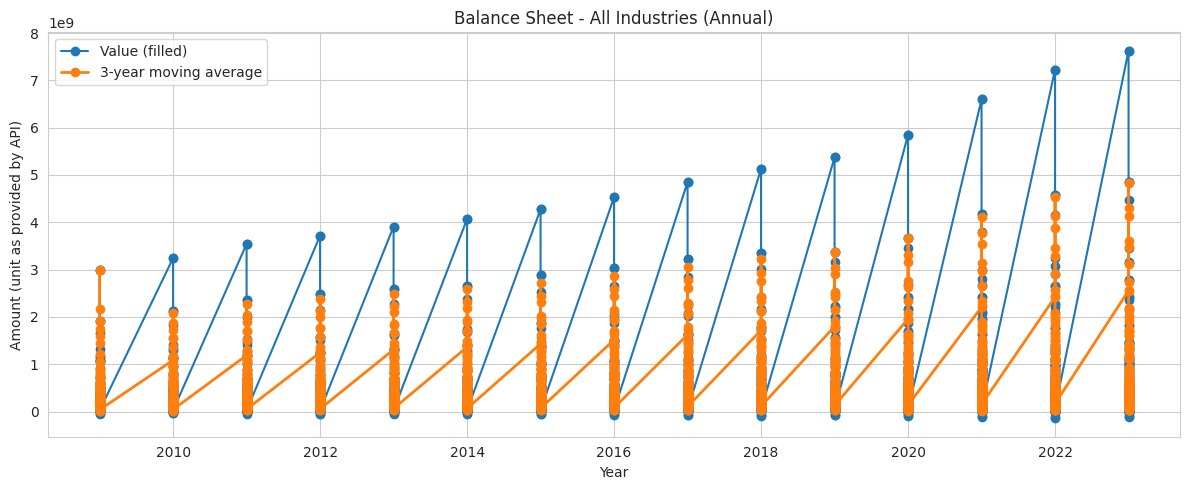

In [28]:
# Visualization (and save)
plt.figure(figsize=(12,5))
plt.plot(df.index.year, df['value_filled'], marker='o', label='Value (filled)')
plt.plot(df.index.year, df['ma_3'], marker='o', label='3-year moving average', linewidth=2)
plt.title('Balance Sheet - All Industries (Annual)')
plt.xlabel('Year')
plt.ylabel('Amount (unit as provided by API)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("timeseries_501Y001_ZZZ00.png", dpi=150)
plt.show()

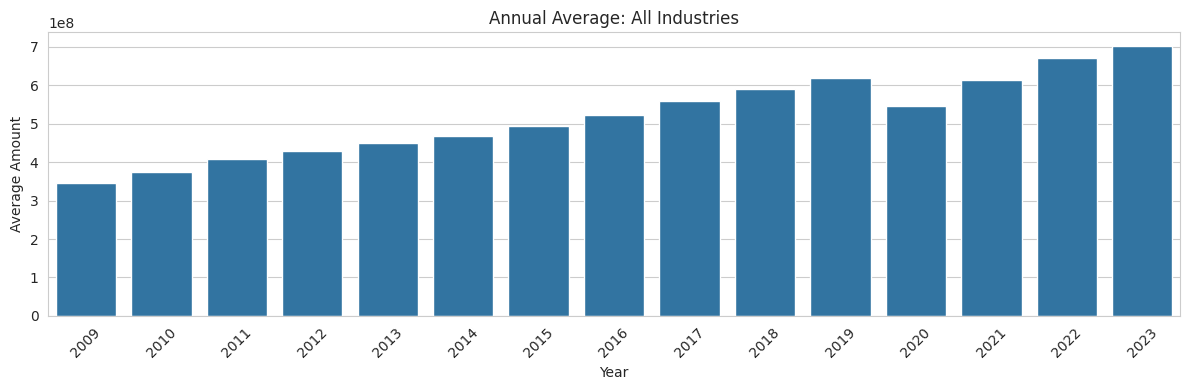

In [29]:
annual = df['value_filled'].resample('YE').mean()
annual.index = annual.index.year
plt.figure(figsize=(12,4))
sns.barplot(x=annual.index.astype(str), y=annual.values)
plt.xticks(rotation=45)
plt.title('Annual Average: All Industries')
plt.xlabel('Year')
plt.ylabel('Average Amount')
plt.tight_layout()
plt.savefig("annual_bar_501Y001_ZZZ00.png", dpi=150)
plt.show()

In [ ]:
# Save CSV
out_fname = f"ecos_{stat_code}_{item_code1}_annual_cleaned.csv"
df.to_csv(out_fname, encoding='utf-8-sig', index=True)
print("Saved:", out_fname)
